<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM/LSTM_Bund10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 144 (delta 69), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (144/144), 119.43 KiB | 1.87 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 14 12:45:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Bund10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 4.3MB/s 
     |████████████████████████████████| 143kB 52.4MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 174kB 49.5MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture
    model = Sequential()

    # input layer
    model.add(LSTM(units=config.input_size, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # second model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # third model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # fourth model layer with dropout
    model.add(LSTM(units=config.hidden_size, activation=config.activation))
    model.add(Dropout(config.dropout))
    # final layer with one output
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: t0orhelp
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM/sweeps/t0orhelp


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: o5su8e3r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 25s 274ms/step - loss: 0.0970 - mean_squared_error: 0.0970 - mean_absolute_error: 0.2443 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1365
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0872 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1323
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0757 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1533
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0778 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1315
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0116 - mean_squared_error: 0

wandb: Agent Starting Run: kqw5eb19 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 62ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1370 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1325
Epoch 2/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0774 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1236
Epoch 3/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0683 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1223
Epoch 4/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0640 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1364
Epoch 5/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0066 - mean_squared_

wandb: Agent Starting Run: 0psf90l3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 58ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1559 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1520
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0657 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1210
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0609 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1247
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0553 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1184
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0064 - mean_squared_error

wandb: Agent Starting Run: yi565fuv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 9s 72ms/step - loss: 0.0757 - mean_squared_error: 0.0757 - mean_absolute_error: 0.1819 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1447
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0668 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1162
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0585 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1173
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0575 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1252
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0060 - mean_squared_

wandb: Agent Starting Run: j9jeiqdx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 7s 111ms/step - loss: 0.0672 - mean_squared_error: 0.0672 - mean_absolute_error: 0.1937 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1313
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0784 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1413
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0574 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1293
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0496 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1223
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0041 - mean_squared

wandb: Agent Starting Run: 8qe5w3yi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 82ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1517 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1369
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0525 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1202
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0503 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1167
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1196
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0039 - mean_squared_error

wandb: Agent Starting Run: 2fr6op3g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 251ms/step - loss: 0.7053 - mean_squared_error: 0.7053 - mean_absolute_error: 0.5011 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1497
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1478 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1359
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1555 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1706
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1401 - val_loss: 0.1177 - val_mean_squared_error: 0.1177 - val_mean_absolute_error: 0.2787
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0507 - mean_squared_error: 0.0507 

wandb: Agent Starting Run: 8hohlzhw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 8s 221ms/step - loss: 0.0873 - mean_squared_error: 0.0873 - mean_absolute_error: 0.2312 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1364
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0868 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1331
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0796 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1441
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0748 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1403
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0150 - mean_squared_error: 0.0150 

wandb: Agent Starting Run: nz8trjah with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 252ms/step - loss: 0.1021 - mean_squared_error: 0.1021 - mean_absolute_error: 0.2668 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1444
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0858 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1417
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0727 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1314
Epoch 4/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0631 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1420
Epoch 5/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0063 - mean_squared_error: 0.0063 

wandb: Agent Starting Run: oq0gw4ah with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 123ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1482 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1267
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0639 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1493
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0643 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1361
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0672 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1517
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0068 - mean_squared

wandb: Agent Starting Run: c4cpwmou with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 78ms/step - loss: 0.0615 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1805 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1417
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0637 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1413
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0609 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1276
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0554 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1243
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0056 - mean_squared_

wandb: Agent Starting Run: 1lbbuf1z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 121ms/step - loss: 0.1025 - mean_squared_error: 0.1025 - mean_absolute_error: 0.2594 - val_loss: 0.0462 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1824
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0964 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1318
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0724 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1271
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0596 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1254
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared

wandb: Agent Starting Run: amgew24v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 243ms/step - loss: 0.1126 - mean_squared_error: 0.1126 - mean_absolute_error: 0.2704 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1396
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0774 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1342
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0646 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1396
Epoch 4/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1447
Epoch 5/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0078 - mean_squared_error: 0.0078 

wandb: Agent Starting Run: wo488kip with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 8s 60ms/step - loss: 0.1163 - mean_squared_error: 0.1163 - mean_absolute_error: 0.2383 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1306
Epoch 2/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0954 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1687
Epoch 3/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0907 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1286
Epoch 4/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0818 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1179
Epoch 5/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0102 - mean_squared_

wandb: Processing terminal ouput (stdout)...
wandb: Done.


wandb: Agent Starting Run: 4bqs21ib with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 68ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1777 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1316
Epoch 2/200
32/32 [==============================] - 1s 19ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0696 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1241
Epoch 3/200
32/32 [==============================] - 1s 18ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0684 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1322
Epoch 4/200
32/32 [==============================] - 1s 18ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0670 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1203
Epoch 5/200
32/32 [==============================] - 1s 19ms/step - loss: 0.0068 - mean_squared_

wandb: Agent Starting Run: m1gfp82w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 8s 281ms/step - loss: 0.0708 - mean_squared_error: 0.0708 - mean_absolute_error: 0.2065 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1319
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0633 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1407
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0920 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1268
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0677 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1295
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0091 - mean_squared_error: 0.

wandb: Agent Starting Run: 2i2tcq6a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 145ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - mean_absolute_error: 0.1689 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1516
Epoch 2/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0820 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1287
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0683 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1264
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0683 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1277
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0089 - mean_squared

wandb: Agent Starting Run: 6aalg4s0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 8s 233ms/step - loss: 0.1130 - mean_squared_error: 0.1130 - mean_absolute_error: 0.2712 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1471
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1056 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1371
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0832 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1334
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0773 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1360
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0081 - mean_squared_error: 0.0081 

wandb: Agent Starting Run: anlewrvf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 327ms/step - loss: 0.0619 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1860 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1788
Epoch 2/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0918 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1472
Epoch 3/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0649 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1610
Epoch 4/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0733 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1512
Epoch 5/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0072 - mean_squared_error: 0.

wandb: Agent Starting Run: njd1nrl1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 8s 324ms/step - loss: 0.1087 - mean_squared_error: 0.1087 - mean_absolute_error: 0.2665 - val_loss: 0.0544 - val_mean_squared_error: 0.0544 - val_mean_absolute_error: 0.1964
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1453 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1644
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - mean_absolute_error: 0.1079 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1463
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0943 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1263
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0086 - mean_squared_error: 0.

wandb: Agent Starting Run: uvvpceuz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 78ms/step - loss: 2.5191 - mean_squared_error: 2.5191 - mean_absolute_error: 0.6430 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1290
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1443 - val_loss: 0.0554 - val_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.1913
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1402 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1220
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0867 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1465
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0150 - mean_squared_

wandb: Agent Starting Run: aeq691nd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 122ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - mean_absolute_error: 0.1688 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1659
Epoch 2/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0941 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1399
Epoch 3/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0779 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1640
Epoch 4/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0884 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1605
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0116 - mean_squared

wandb: Agent Starting Run: 1wsvbln2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 7s 61ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - mean_absolute_error: 0.1917 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1289
Epoch 2/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0890 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1678
Epoch 3/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0772 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1103
Epoch 4/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0621 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1599
Epoch 5/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0081 - mean_squared_

wandb: Agent Starting Run: q2i11qcs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 7s 219ms/step - loss: 0.1045 - mean_squared_error: 0.1045 - mean_absolute_error: 0.2584 - val_loss: 0.0600 - val_mean_squared_error: 0.0600 - val_mean_absolute_error: 0.2101
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1216 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1546
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0849 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1538
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0820 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1256
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0065 - mean_squared_error: 0.

wandb: Agent Starting Run: fitdhxkk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 8s 64ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1590 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1252
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0768 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1239
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0666 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1303
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0690 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1224
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0065 - mean_squared_

wandb: Agent Starting Run: 7bul33y4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 7s 223ms/step - loss: 0.1531 - mean_squared_error: 0.1531 - mean_absolute_error: 0.2922 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1428
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0702 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1390
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0637 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1487
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0721 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1562
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0104 - mean_squared_error: 0.0104 

wandb: Agent Starting Run: r8kz1760 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 8s 67ms/step - loss: 0.3494 - mean_squared_error: 0.3494 - mean_absolute_error: 0.3136 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1320
Epoch 2/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0678 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1061
Epoch 3/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0432 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1084
Epoch 4/200
32/32 [==============================] - 1s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0426 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0971
Epoch 5/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0033 - mean_squared_

wandb: Agent Starting Run: kv11ndog with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 8s 64ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1474 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1638
Epoch 2/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0660 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1675
Epoch 3/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0640 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1303
Epoch 4/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0578 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1238
Epoch 5/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0058 - mean_squared_error

wandb: Agent Starting Run: 8u6dormu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 8s 113ms/step - loss: 0.1020 - mean_squared_error: 0.1020 - mean_absolute_error: 0.2611 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1380
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1044 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1301
Epoch 3/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0828 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1372
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0834 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1267
Epoch 5/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0106 - mean_squared

wandb: Agent Starting Run: s7q0huhx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 9s 69ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1581 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - val_mean_absolute_error: 0.1872
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0811 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1551
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0630 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1431
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0581 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1064
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0064 - mean_squared_

wandb: Agent Starting Run: 0v2w6t2z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 9s 65ms/step - loss: 0.0853 - mean_squared_error: 0.0853 - mean_absolute_error: 0.2224 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1098
Epoch 2/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0536 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1017
Epoch 3/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0624 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1182
Epoch 4/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0642 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0932
Epoch 5/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0039 - mean_squared_error

wandb: Agent Starting Run: xyfiyi7q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 115ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1474 - val_loss: 0.0504 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1917
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0831 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1281
Epoch 3/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0658 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1247
Epoch 4/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0660 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1225
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0075 - mean_squared

wandb: Agent Starting Run: kfnata3z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 8s 111ms/step - loss: 0.1459 - mean_squared_error: 0.1459 - mean_absolute_error: 0.3055 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1562
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1149 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1261
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0786 - val_loss: 0.0575 - val_mean_squared_error: 0.0575 - val_mean_absolute_error: 0.1917
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.0982 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1711
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0124 - mean_squared

wandb: Agent Starting Run: o9e3ot87 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 225ms/step - loss: 0.1123 - mean_squared_error: 0.1123 - mean_absolute_error: 0.2710 - val_loss: 0.0574 - val_mean_squared_error: 0.0574 - val_mean_absolute_error: 0.2058
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1254 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1497
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0879 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1386
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0723 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1239
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0073 - mean_squared_error: 0.

wandb: Agent Starting Run: 2btoidr4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 171ms/step - loss: 0.1069 - mean_squared_error: 0.1069 - mean_absolute_error: 0.2556 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1375
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0708 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1351
Epoch 3/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0556 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1347
Epoch 4/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0542 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1298
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0051 - mean_squared

wandb: Agent Starting Run: yeejk8mx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 8s 67ms/step - loss: 1.3762 - mean_squared_error: 1.3762 - mean_absolute_error: 0.4980 - val_loss: 0.1361 - val_mean_squared_error: 0.1361 - val_mean_absolute_error: 0.3130
Epoch 2/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1304 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1475
Epoch 3/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1128 - val_loss: 0.5807 - val_mean_squared_error: 0.5807 - val_mean_absolute_error: 0.7253
Epoch 4/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0984 - mean_squared_error: 0.0984 - mean_absolute_error: 0.2188 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1134
Epoch 5/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0106 - mean_squared_

wandb: Agent Starting Run: c9dpodp2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 9s 123ms/step - loss: 0.0844 - mean_squared_error: 0.0844 - mean_absolute_error: 0.2277 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1350
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0810 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1457
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0648 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1404
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0518 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1316
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0037 - mean_squared

wandb: Agent Starting Run: j0i5ouat with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 8s 114ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1492 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1347
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0741 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1451
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0497 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1320
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0488 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1424
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0041 - mean_squared

wandb: Agent Starting Run: 7uwg50v9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 232ms/step - loss: 0.1109 - mean_squared_error: 0.1109 - mean_absolute_error: 0.2647 - val_loss: 0.0694 - val_mean_squared_error: 0.0694 - val_mean_absolute_error: 0.2075
Epoch 2/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1331 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1346
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0783 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1539
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0608 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1200
Epoch 5/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0045 - mean_squared_error: 0.

wandb: Agent Starting Run: bo6w1c5z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 238ms/step - loss: 0.0890 - mean_squared_error: 0.0890 - mean_absolute_error: 0.2296 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1350
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0964 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1303
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0963 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1317
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0828 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1291
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0149 - mean_squared_error: 0.

wandb: Agent Starting Run: s62dfs33 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Ctrl + C detected. Stopping sweep.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [18]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 64,
    'dropout': 0.2,
    'input_size': 100,
    'hidden_size': 25,
    'learning_rate': 0.001,
    'optimizer': 'rmsprop',
    'activation': 'tanh'
}

In [19]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(LSTM(units=best_config['input_size'], return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# second model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# third model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# fourth model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# final layer with one output
model.add(Dense(units=1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  63626


In [20]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
20/20 [==============================] - 5s 9ms/step - loss: 0.0467
Epoch 2/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 3/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0102
Epoch 4/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0092
Epoch 5/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 6/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0073
Epoch 7/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 8/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 9/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0072
Epoch 10/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 11/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 12/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 13/200
20/20 [================

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

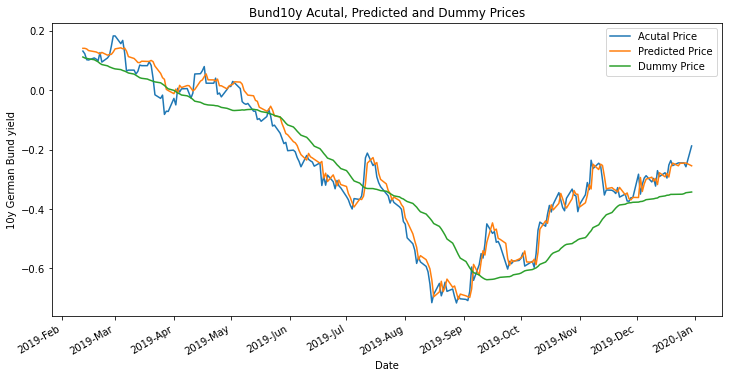

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

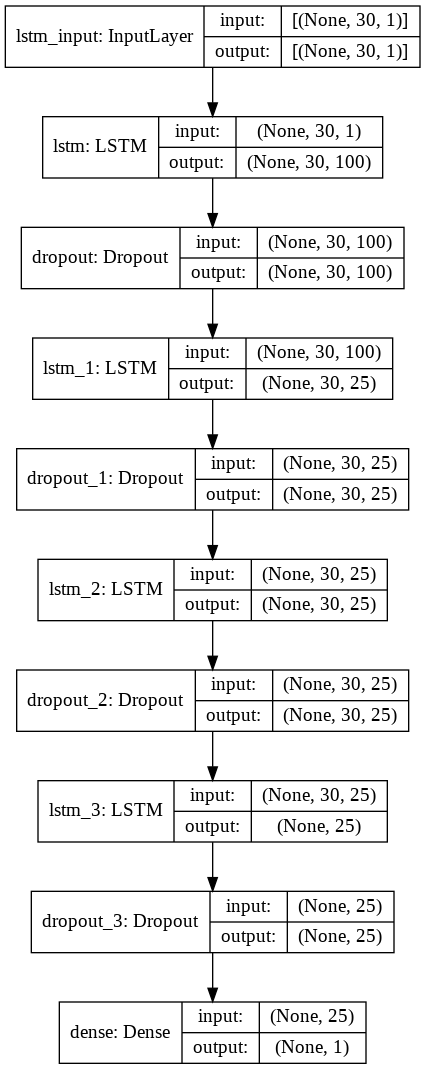

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.0028950864773452127
RMSE:  0.05380600781832093
MAE:  0.04307379340088317


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Bund10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Bund10y/assets
